# MNIST classification

**Course:** 02506 Advanced Image Analysis Spring 21

**Authors:**  Allan Erlang Videbæk (s164197), Mads Emil Dahlgaard (s164206) and Niels Asp Nielsen (s164181).

***

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from helpers import read_mnist, format_data, load_nn

## Instructions

This notebook serves as a demonstration of the trained MNIST classifier. Run this notebook to get classification results on previously unseen data.

## Method

## Code structure

The only used 3rd party library is NumPy.

## Run on new data 

### Load data and neural network model

In [2]:
im_path = 'mnist/t10k-images-idx3-ubyte'
lab_path = 'mnist/t10k-labels-idx1-ubyte'
ims, labels, a, t = read_mnist()
# Format X as (n_obs, n_features) and onehot encode y.
X, y = format_data(ims, labels)

TypeError: read_mnist() got an unexpected keyword argument 'data'

In [65]:
print(f"Shape of X: {X.shape}, shape of y: {y.shape}")

Shape of X: (10000, 784), shape of y: (10000, 10)


In [66]:
# Load neural network model.
nn = load_nn('models/best_nn.pkl')

### Run and evaluate model on the data

In [34]:
yhat, _, _ = nn.forward(X)
pred_labels = np.argmax(yhat,axis=1)

In [67]:
print(f"The classification error is {np.mean(pred_labels==labels)}.")

The classification error is 0.9883.


### Investigating the misclassifications

In [74]:
# Get missclassifications.
misses = pred_labels!=labels
miss_preds = pred_labels[misses]
miss_labels = labels[misses]
miss_ims = ims[misses]

In [75]:
print(f"Total misclassifications: {len(miss_labels)}")
for i in range(10):
    print(f"Misclassifications with true label {i}: {np.sum(miss_labels==i)}.")

Total misclassifications: 117
Misclassifications with true label 0: 3.
Misclassifications with true label 1: 7.
Misclassifications with true label 2: 15.
Misclassifications with true label 3: 13.
Misclassifications with true label 4: 14.
Misclassifications with true label 5: 17.
Misclassifications with true label 6: 7.
Misclassifications with true label 7: 11.
Misclassifications with true label 8: 14.
Misclassifications with true label 9: 16.


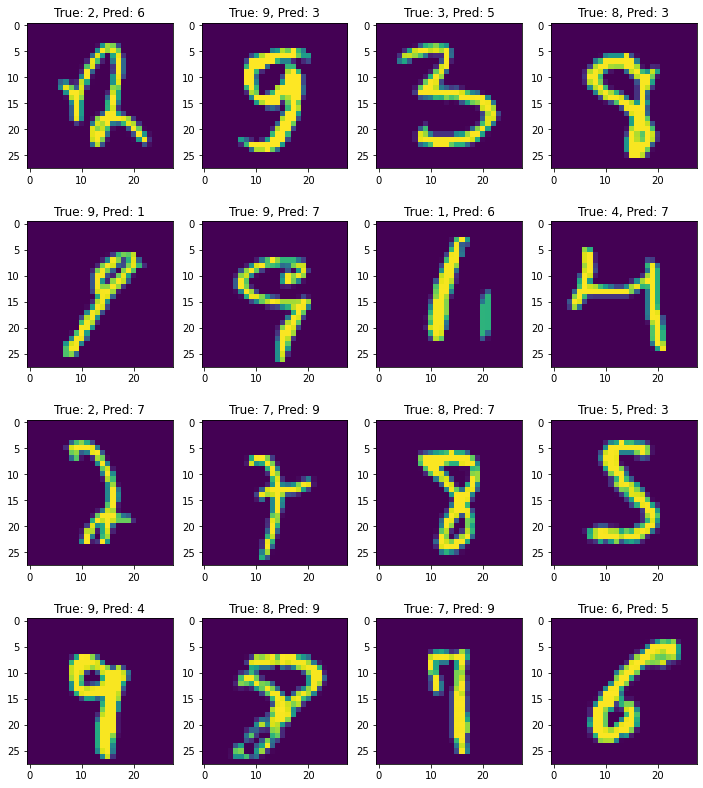

In [76]:
fig, ax = plt.subplots(4,4,figsize=(12,14)) 
ax = ax.ravel()
idxs = np.random.permutation(miss_ims.shape[0])

if len(idxs) < 16:
    print("Less than 16 misclassifications.")
else:
    for i in range(16):
        idx = idxs[i]
        ax[i].imshow(miss_ims[idx])
        ax[i].set_title(f'True: {miss_labels[idx]}, Pred: {miss_preds[idx]}')
    plt.show()